In [33]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [34]:
WINDOW_SIZE = 120
BATCH_SIZE = 5
N_EPOCHS = 10
PATH = 'data/sunspots.csv'

In [35]:
def load_data(path):
    df = pd.read_csv(path)
    df.columns = ['x', 'date', 'monthly_mean_sunspots']
    df = df.set_index('date')
    df = df['monthly_mean_sunspots']
    df.index = pd.to_datetime(df.index, format='%Y-%m-%d')
    df = df.asfreq('ME')
    return df

df = load_data(PATH)

time = df.index
series = df.values

In [36]:
test_size = 800
val_size = 200

train_val_series, train_val_time = series[:-test_size], time[:-test_size]
test_series, test_time = series[-test_size:], time[-test_size:]

train_series, train_time = train_val_series[:-val_size], train_val_time[:-val_size]
val_series, val_time = train_val_series[-val_size:], train_val_time[-val_size:]
 
train_series = train_series.reshape((len(train_series), 1))
val_series = val_series.reshape((len(val_series), 1))
test_series  = test_series.reshape((len(test_series), 1))

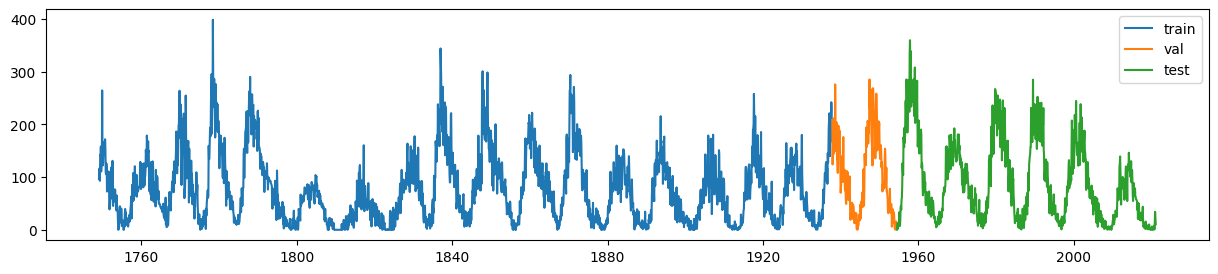

In [37]:
fig, ax = plt.subplots(figsize=(15, 3))
ax.plot(train_time, train_series, label='train')
ax.plot(val_time, val_series, label='val')
ax.plot(test_time, test_series, label='test')
ax.legend()
plt.show()

In [38]:
train_generator = TimeseriesGenerator(
    train_series, 
    train_series,
    length=WINDOW_SIZE, 
    sampling_rate=1,
    stride=1,
    batch_size=BATCH_SIZE
)

val_generator = TimeseriesGenerator(
    val_series, 
    val_series,
    length=WINDOW_SIZE, 
    sampling_rate=1,
    stride=1,
    batch_size=BATCH_SIZE
)

test_generator = TimeseriesGenerator(
    test_series, 
    test_series,
    length=WINDOW_SIZE, 
    sampling_rate=1,
    stride=1,
    batch_size=BATCH_SIZE
)

In [39]:
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=(WINDOW_SIZE, 1)),
    tf.keras.layers.LSTM(2, activation='relu'),
    tf.keras.layers.Dense(1)
])
model.compile(optimizer='adam', loss='mse')

In [ ]:
history = model.fit(train_generator, validation_data=val_generator, epochs=N_EPOCHS, verbose=1)

Epoch 1/10
  1/429 ━━━━━━━━━━━━━━━━━━━━ 39:54 6s/step - loss: 9920.9238

c:\users\robet\venvs\.deepl\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


429/429 ━━━━━━━━━━━━━━━━━━━━ 28s 52ms/step - loss: 10916.6357 - val_loss: 19606.6445
Epoch 2/10
382/429 ━━━━━━━━━━━━━━━━━━━━ 2s 45ms/step - loss: 9419.0781

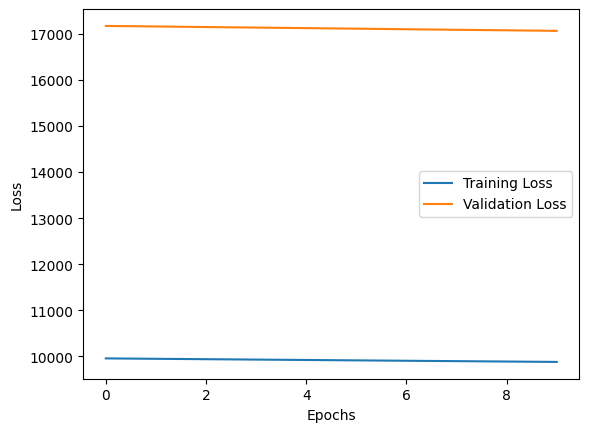

In [32]:
fig, ax = plt.subplots()
ax.plot(history.history['loss'], label='Training Loss')
ax.plot(history.history['val_loss'], label='Validation Loss')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
plt.legend()
plt.show()

In [1]:
test_predictions = model.predict(test_generator)
train_predictions = model.predict(train_generator)

NameError: name 'model' is not defined

In [2]:
fig, ax = plt.subplots(figsize=(15, 5))
ax.plot(train_time, train_series, ':', color='black', label='y_train')
ax.plot(train_time[WINDOW_SIZE:], train_predictions, color='gray', linewidth=0.5, label='y_train_pred')

ax.plot(test_time, test_series, ':')
ax.plot(test_time[WINDOW_SIZE:], test_predictions)
plt.show()

NameError: name 'plt' is not defined

In [71]:
ypred = []
ytest = []
for batch in test_ds:
    inputs, targets = batch
    ypred_batch = model.predict(inputs, verbose=0)
    ypred.extend(ypred_batch.flatten())
    ytest.extend(targets.numpy().flatten())

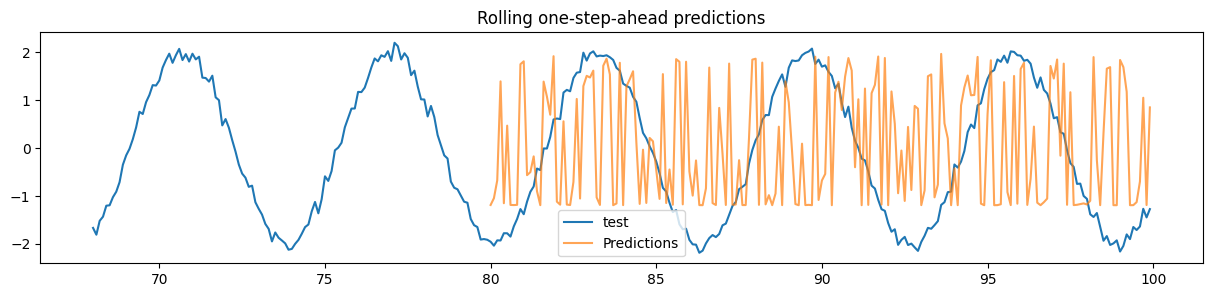

In [72]:
fig, ax = plt.subplots(figsize=(15, 3))
ax.plot(test_time, test_series, label='test')
ax.plot(test_time[WINDOW_SIZE:], ypred, label='Predictions', alpha=0.7)
ax.legend()
ax.set_title('Rolling one-step-ahead predictions')
plt.show()